## Feature Importance Analysis (SHAP)


### Imports

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from imports import *

In [5]:
from models import *
from data import * 
from env import *
from sim import *
from sim import sim_run
from sim import plot

# overall imports
import importlib
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run, open_pickled_results

import data.data_utils

# cross-validation classes
from data.cv_split import (
    RandomCVSplit, 
    SchaeferCVSplit, 
    CommunityCVSplit, 
    SubnetworkCVSplit
)
import data.cv_split

from data.data_load import load_transcriptome, load_connectome, load_coords


In [6]:
# Specify path to saved simulations
feature_types = ['transcriptome', 'transcriptomePCA', 'structural', 'euclidean', 'functional']
sim_path = os.getcwd() + '/sim/sim_results/'
os.listdir(sim_path)

['transcriptome_FC_xgboost_random_2_bayes_mse_search.pickle',
 'single_sim_results']

Update conda environment beforehand as follows:

conda env update --name main_env --file GeneEx2Conn_env_combined.yml

**^Do this in your singularity container and replace main_env with whatever the environment name is...**


### Sim Run with XGBoost Model Saved as JSON within Sim Results Pickle

In [ ]:
results = single_sim_run(
                        cv_type='random',
                        model_type='xgboost',
                        feature_type=['transcriptome'],
                        use_gpu=True,
                        use_shared_regions=False,
                        test_shared_regions=False,
                        random_seed=2,
                        save_sim=True,
                        save_model_json=True,
                        search_method=('bayes', 'mse')
                        )

In [7]:
results = open_pickled_results('transcriptome_FC_xgboost_random_2_bayes_mse_search.pickle')

In [8]:
# Example loop to show how to extract the model from each train-test fold
# In this case there are 4 folds, thus 4 models 

for fold in results[0]: 
    print(fold.keys())
    print(fold['train_metrics'])
    print(fold['test_metrics']) # this will be replaced with model_json

dict_keys(['model_parameters', 'train_metrics', 'best_val_score', 'test_metrics', 'y_true', 'y_pred', 'feature_importances', 'model_json'])
{'mse': 0.014831279731915075, 'mae': 0.0819091276066069, 'r2': 0.30564890908261627, 'pearson_corr': 0.7869500066076349, 'connectome_corr': 0.6522652776969675, 'connectome_r2': 0.2771600170159091, 'geodesic_distance': 9.746608503490942}
{'mse': 0.02148450804813151, 'mae': 0.11211099762817703, 'r2': -0.23965096286954973, 'pearson_corr': 0.4632457959399317, 'connectome_corr': 0.304487509853925, 'connectome_r2': -0.5537247314253684, 'geodesic_distance': 5.473043482546301}
dict_keys(['model_parameters', 'train_metrics', 'best_val_score', 'test_metrics', 'y_true', 'y_pred', 'feature_importances', 'model_json'])
{'mse': 3.42345573209367e-05, 'mae': 0.004373363049060336, 'r2': 0.9958498700530615, 'pearson_corr': 0.9995398704167768, 'connectome_corr': 0.9980582036104715, 'connectome_r2': 0.9955852801581779, 'geodesic_distance': 2.757046740790688}
{'mse': 0.

Training and testing data to compute shap values with

In [9]:
# Corresponding data for each fold - make sure identical to above simulation
X = load_transcriptome()
Y = load_connectome(measure='FC')
random_obj = RandomCVSplit(X, Y, num_splits=4, shuffled=True, use_random_state=True, random_seed=2)

fold_splits = process_cv_splits(X, Y, random_obj)

In [10]:
for fold_idx, (X_train, X_test, y_train, y_test) in enumerate(fold_splits):
    print(fold_idx+1)
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)

1
(7140, 22106)
(7140,)
(812, 22106)
(812,)
2
(7140, 22106)
(7140,)
(812, 22106)
(812,)
3
(7310, 22106)
(7310,)
(756, 22106)
(756,)
4
(7310, 22106)
(7310,)
(756, 22106)
(756,)


- Will need to use the above train, test splits to evaluate feature importance. https://github.com/shap/shap
- Can use train set, test set, or both to explain feature importance. Let's run all 3 variations for now
- Can also evaluate genes that are most stable over all folds as an indicator of which genes are stable across the brain.

In [11]:
import xgboost as xgb

model = xgb.Booster()
model_json = results[0][0]['model_json'] # fold 0 trained model
model.load_model(bytearray(model_json, 'utf-8'))
model

# do Tree SHAP from here...

In [27]:
import shap

schaefer114_genes = pd.read_csv("./data/enigma/allgenes_stable_r0.2_schaefer_100.csv")
gene_list = list(pd.unique(["1_" + x for x in schaefer114_genes.columns[1:].tolist()] +
                           ["2_" + x for x in schaefer114_genes.columns[1:].tolist()]))

explainer = shap.TreeExplainer(model)

def plot_shap_values(exp, dataset, columns):
    dataset = pd.DataFrame(dataset, columns=columns)
    shap_values = exp.shap_values(dataset)
    shap.summary_plot(shap_values, dataset)

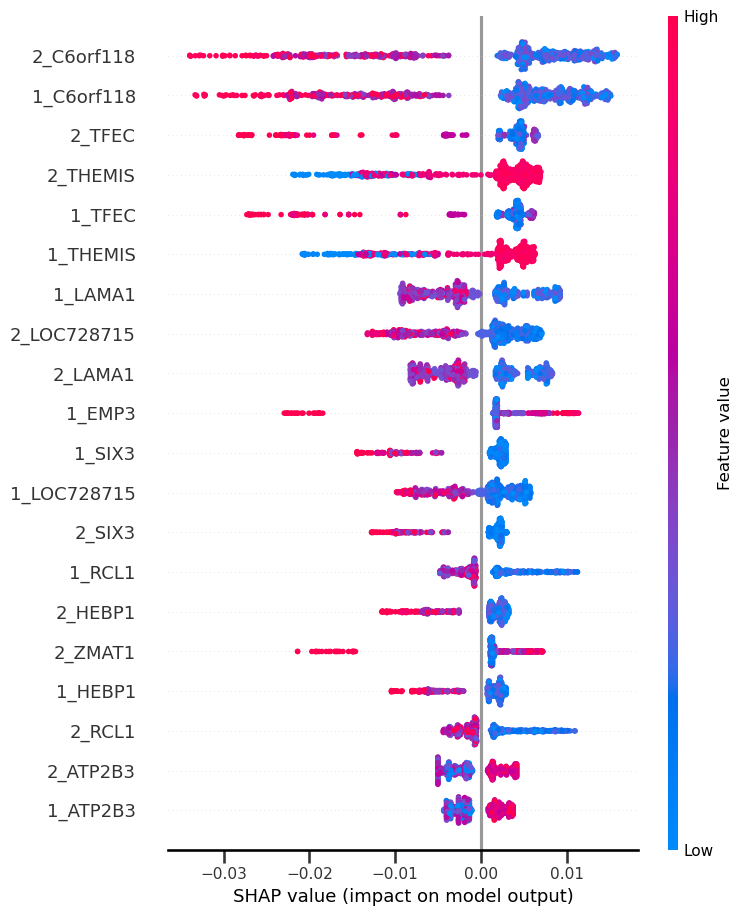

In [28]:
plot_shap_values(explainer, X_test, gene_list)

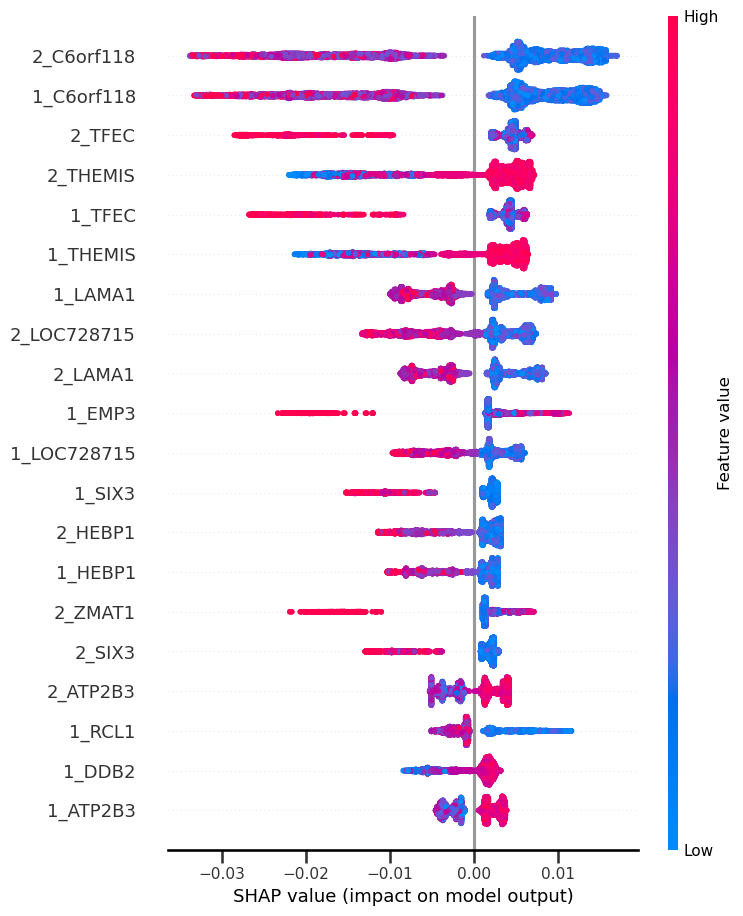

In [29]:
plot_shap_values(explainer, X_train, gene_list)

### Feature Importance for Previously Run Simulations

In [7]:
# HELPER FUNCS FOR GAIN FEATURE IMPORTANCE MEASURE
def load_filtered_results(base_path, input_features=None, split_type=None, model_type=None, search_type=None):
    """
    Load simulation results filtered by specified parameters.
    
    Parameters:
    -----------
    base_path : str
        Base path where pickle files are stored
    input_features : str or list, optional
        Input feature type(s) (e.g., 'transcriptome', 'structural', 'functional')
    split_type : str, optional
        Split type (e.g., 'random', 'community101', 'community102')
    model_type : str, optional
        Model type (e.g., 'xgboost', 'ridge', 'pls')
    search_type : str, optional
        Search type (e.g., 'gridsearch', 'bayessearch')
    
    Returns:
    --------
    list
        List of loaded results matching the specified criteria
    """
    # Get all pickle files
    all_files = [f for f in os.listdir(base_path) if f.endswith('.pickle')]
    filtered_files = all_files.copy()
    
    # Convert input_features to list if string
    if isinstance(input_features, str):
        input_features = [input_features]
    
    # Filter by input features
    if input_features:
        filtered_files = []
        for f in all_files:
            # Split filename by underscore and get feature part
            features = f.split('_')[0]
            # Check if features exactly match any of the input_features
            if features in input_features:
                # Ensure no additional features are present
                if len(f.split('_')[0].split()) == 1:
                    filtered_files.append(f)
    
    # Filter by model type
    if model_type:
        filtered_files = [f for f in filtered_files if model_type in f]
    
    # Filter by split type
    if split_type:
        filtered_files = [f for f in filtered_files if split_type in f]
    
    # Filter by search type
    if search_type:
        filtered_files = [f for f in filtered_files if search_type in f]
    
    
    # Load results
    results = []
    for file in filtered_files:
        print(f"Loading {file}")
        result = open_pickled_results(file, added_dir='SFN_runs_mse/', backup=True)
        results.append(result[0])
    
    return results

def compute_mean_feature_importances(results, combine_regions=False):
    """
    Computes the mean feature importances across all folds and simulations.

    Parameters:
    - results: List of lists containing simulation results, each with a dictionary that includes 'feature_importances'.
    - combine_regions: If True, averages the first and second half of features, assuming they represent the same genes
                      from two different regions. If False, keeps all features separate.

    Returns:
    - mean_importances: A numpy array containing the mean importance for each feature.
    """
    # Initialize a list to collect all feature importances
    all_importances = []

    # Step 1: Extract feature importances
    for sim_result in results:
        for fold_result in sim_result:
            # Assuming fold_result is a dictionary containing 'feature_importances'
            feature_importances = fold_result['feature_importances']
            all_importances.append(feature_importances)
    
    # Convert to a numpy array for easier manipulation
    all_importances = np.array(all_importances)
    
    # Step 2: Calculate the mean importance for each feature
    mean_importances = np.mean(all_importances, axis=0)
    
    # Step 3: Optionally combine regions
    if combine_regions:
        n_features = len(mean_importances)
        if n_features % 2 != 0:
            raise ValueError("Number of features must be even to combine regions")
            
        half_length = n_features // 2
        mean_importances = (mean_importances[:half_length] + mean_importances[half_length:]) / 2
    
    return mean_importances

def plot_mean_feature_importances(mean_importances, combine_regions=False):
    """
    Plots the mean feature importances as a bar plot.

    Parameters:
    - mean_importances: A numpy array containing the mean importance for each feature.
    - combine_regions: Boolean indicating whether the importances represent combined regions.
                      Affects the x-axis labeling.
    """
    plt.figure(figsize=(12, 8))
    plt.bar(np.arange(len(mean_importances)), mean_importances, width=2.0, edgecolor='none')
    
    title = 'Average Feature Importances Across All Folds and Simulations'
    if combine_regions:
        title += ' (Combined Regions)'
    plt.title(title)
    
    xlabel = 'Gene Index' if combine_regions else 'Feature Index'
    plt.xlabel(xlabel)
    plt.ylabel('Average Importance')
    plt.tight_layout()  # Optimize layout to reduce rendering time
    plt.show()


def plot_feature_importances_with_folds(results, combine_regions=False, show_mean=True, sim_idx=None):
    """
    Plots individual fold feature importances as translucent bars with optional mean importance overlay.
    
    Parameters:
    - results: List of simulation results containing feature importances for each fold
    - combine_regions: Boolean indicating whether to combine region importances
    - show_mean: Boolean indicating whether to show the mean importance overlay
    - sim_idx: Optional index of specific simulation to plot. If None, plots all simulations.
    """
    # Get mean importances using existing function
    mean_importances = compute_mean_feature_importances(results, combine_regions=combine_regions)
    
    # Extract fold importances
    all_importances = []
    if sim_idx is not None:
        if sim_idx >= len(results):
            raise ValueError(f"sim_idx {sim_idx} is out of range for results of length {len(results)}")
        sim_result = results[sim_idx]
        for fold_result in sim_result:
            feature_importances = fold_result['feature_importances']
            if combine_regions:
                n_features = len(feature_importances)
                half_length = n_features // 2
                combined_importances = (feature_importances[:half_length] + 
                                      feature_importances[half_length:]) / 2
                all_importances.append(combined_importances)
            else:
                all_importances.append(feature_importances)
    else:
        for sim_result in results:
            for fold_result in sim_result:
                feature_importances = fold_result['feature_importances']
                if combine_regions:
                    n_features = len(feature_importances)
                    half_length = n_features // 2
                    combined_importances = (feature_importances[:half_length] + 
                                          feature_importances[half_length:]) / 2
                    all_importances.append(combined_importances)
                else:
                    all_importances.append(feature_importances)
    
    # Create plot
    plt.figure(figsize=(12, 8))
    
    x = np.arange(len(mean_importances))
    
    # Plot each fold's importances as translucent blue bars
    for fold_importance in all_importances:
        plt.bar(x, fold_importance, width=2.0, color='blue', alpha=0.1, edgecolor='none')
    
    # Optionally plot mean importance overlay
    if show_mean:
        plt.bar(x, mean_importances, width=1.0, color='red', alpha=1.0, edgecolor='none',
                label='Mean Importance')

    title = 'Feature Importances Across '
    title += f'Simulation {sim_idx} ' if sim_idx is not None else 'All Simulations '
    title += 'and Folds'
    if combine_regions:
        title += ' (Combined Regions)'
    plt.title(title)
    
    xlabel = 'Gene Index' if combine_regions else 'Feature Index'
    plt.xlabel(xlabel)
    plt.ylabel('Importance')
    if show_mean:
        plt.legend()
    plt.tight_layout()
    plt.show()

#### Example Feature Importance Viz (Gain) for Random CV Split TranscriptomePCA

In [ ]:
# may only work locally for asr655
feature_types = ['transcriptome', 'transcriptomePCA', 'structural', 'euclidean', 'functional']
SFN_sim_path = os.getcwd() + '_backup/sim/sim_results/SFN_runs_mse'
os.listdir(SFN_sim_path)

Loading transcriptomePCA_xgboost_random_2_bayessearch.pickle
Loading transcriptomePCA_xgboost_random_7_bayessearch.pickle
Loading transcriptomePCA_xgboost_random_8_bayessearch.pickle
Loading transcriptomePCA_xgboost_random_1_bayessearch.pickle
Loading transcriptomePCA_xgboost_random_5_bayessearch.pickle
Loading transcriptomePCA_xgboost_random_42_bayessearch.pickle
Loading transcriptomePCA_xgboost_random_6_bayessearch.pickle
Loading transcriptomePCA_xgboost_random_3_bayessearch.pickle
Loading transcriptomePCA_xgboost_random_9_bayessearch.pickle
Loading transcriptomePCA_xgboost_random_4_bayessearch.pickle


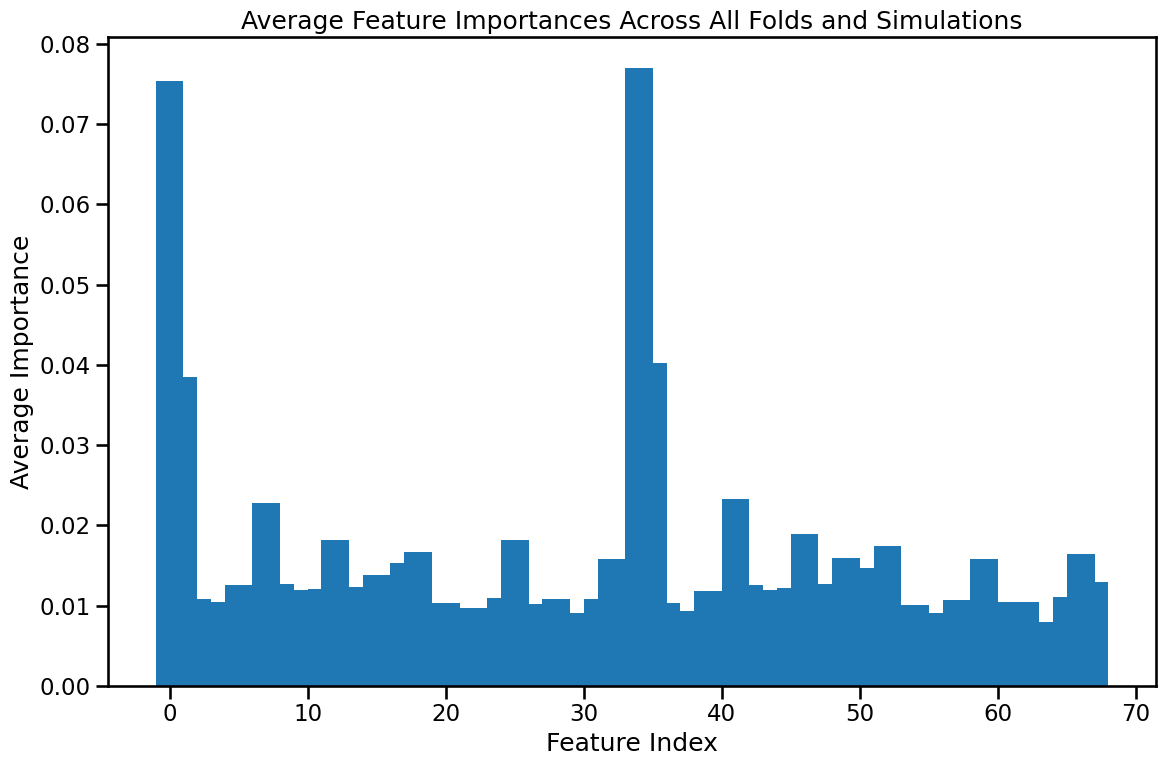

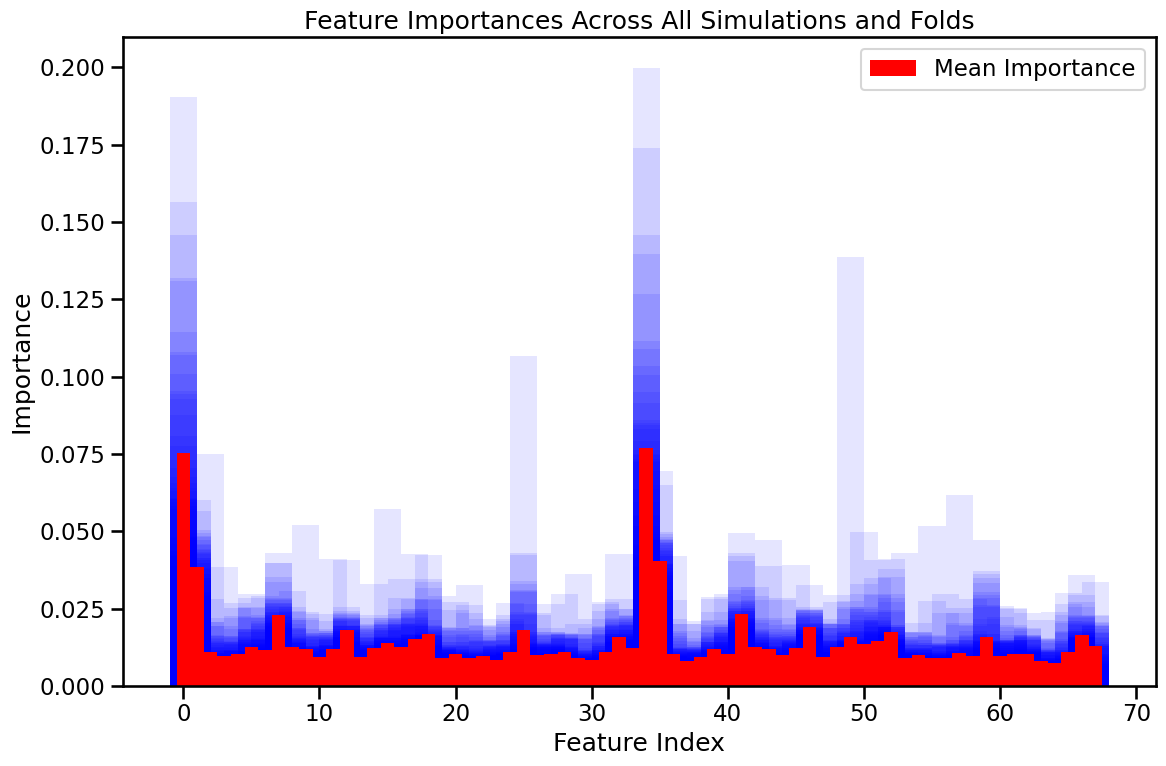

In [8]:
results = load_filtered_results(
    base_path=SFN_sim_path,
    input_features=['transcriptomePCA'],  # Can be single string or list
    split_type='random',
    model_type='xgboost',
    search_type='bayessearch'
)

combine_regions=False
mean_importances = compute_mean_feature_importances(results, combine_regions=combine_regions)

plot_mean_feature_importances(mean_importances, combine_regions=combine_regions)
plot_feature_importances_with_folds(results, combine_regions=combine_regions, show_mean=True, sim_idx=None)
